## **A System to classify multiple emotions (e.g., joy, sadness, anger) present intextual data.**


### Downloading Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debarshichanda/goemotions")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/goemotions


In [2]:
!pip install torch transformers datasets scikit-learn

### Importing necessary libraries

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

### Making a dataframe from the downloaded dataset

In [4]:
df = pd.read_csv(os.path.join(path, "/kaggle/input/goemotions/data/full_dataset/goemotions_1.csv"))

In [5]:
df.head(3)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1


### Checking overall information about the dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  70000 non-null  object 
 1   id                    70000 non-null  object 
 2   author                70000 non-null  object 
 3   subreddit             70000 non-null  object 
 4   link_id               70000 non-null  object 
 5   parent_id             70000 non-null  object 
 6   created_utc           70000 non-null  float64
 7   rater_id              70000 non-null  int64  
 8   example_very_unclear  70000 non-null  bool   
 9   admiration            70000 non-null  int64  
 10  amusement             70000 non-null  int64  
 11  anger                 70000 non-null  int64  
 12  annoyance             70000 non-null  int64  
 13  approval              70000 non-null  int64  
 14  caring                70000 non-null  int64  
 15  confusion          

In [7]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

### As there are many columns in the dataframe that are not usefull for our task, so we will consider only the columns having "text" data and the columns have "emotions".

In [8]:
# Identify text and label columns
text_column = "text"
label_columns = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization", "relief",
    "remorse", "sadness", "surprise", "neutral"
]

In [9]:
df2 = df[[text_column] + label_columns]

### Now the dataframe is ready according to our task

In [10]:
df2.head(3)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Now loading Tokenizer

In [12]:
import pandas as pd
from transformers import AutoTokenizer

In [13]:
model_name = "bert-base-uncased"  # You can choose a different model
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Tokenizing the text Column

In [14]:
# Define maximum token length
MAX_LEN = 128

# Tokenize the text column
tokenized_data = tokenizer(
    df2["text"].tolist(),  # Convert text column to a list
    padding="max_length",  # Pad sequences to max length
    truncation=True,       # Truncate sequences longer than max length
    max_length=MAX_LEN,    # Set max token length
    return_tensors="pt"    # Return PyTorch tensors
)

# The output contains input_ids, attention_mask, and (optionally) token_type_ids
input_ids = tokenized_data["input_ids"]
attention_mask = tokenized_data["attention_mask"]

### Checking the tokenized output

In [15]:
# Decode a sample from input_ids
print("Original Text:", df2["text"].iloc[0])
print("Tokenized Input IDs:", input_ids[0])
print("Decoded Tokens:", tokenizer.decode(input_ids[0]))

Original Text: That game hurt.
Tokenized Input IDs: tensor([ 101, 2008, 2208, 3480, 1012,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
Decoded Tokens: [CLS] that game hurt. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            70000 non-null  object
 1   admiration      70000 non-null  int64 
 2   amusement       70000 non-null  int64 
 3   anger           70000 non-null  int64 
 4   annoyance       70000 non-null  int64 
 5   approval        70000 non-null  int64 
 6   caring          70000 non-null  int64 
 7   confusion       70000 non-null  int64 
 8   curiosity       70000 non-null  int64 
 9   desire          70000 non-null  int64 
 10  disappointment  70000 non-null  int64 
 11  disapproval     70000 non-null  int64 
 12  disgust         70000 non-null  int64 
 13  embarrassment   70000 non-null  int64 
 14  excitement      70000 non-null  int64 
 15  fear            70000 non-null  int64 
 16  gratitude       70000 non-null  int64 
 17  grief           70000 non-null  int64 
 18  joy   

### Checking If the dataset is imbalanced

In [22]:
# Count how many times each emotion appears
emotion_counts = df2.iloc[:, 1:].sum().sort_values(ascending=False)  # Assuming first column is "text"

# Display emotion distribution
print(emotion_counts)


neutral           18423
approval           5928
admiration         5647
annoyance          4443
gratitude          3863
disapproval        3774
curiosity          3267
amusement          3081
optimism           2887
realization        2867
disappointment     2771
love               2745
joy                2607
anger              2589
confusion          2471
sadness            2193
caring             1988
excitement         1900
surprise           1806
disgust            1704
desire             1248
fear               1048
remorse             849
embarrassment       817
nervousness         598
relief              452
pride               452
grief               227
dtype: int64


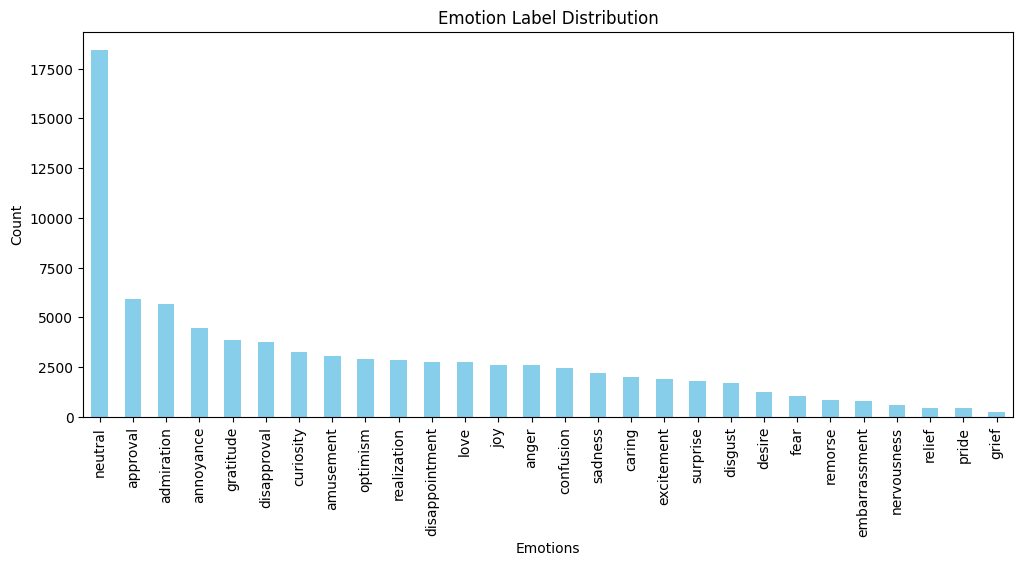

In [23]:
import matplotlib.pyplot as plt

# Plot the emotion distribution
plt.figure(figsize=(12, 5))
emotion_counts.plot(kind="bar", color="skyblue")
plt.title("Emotion Label Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

### As we know from the above graph that the dataset is highly imabalanced So, we have to balance the dataset fiirst

### Setting an imbalance threshold

In [24]:
imbalance_threshold = 0.05 * len(df2)  # 3% of total samples

In [25]:
print(imbalance_threshold)

3500.0


### Finding rare emotions (emotions that are less than the threshold) and common emotions (emotions that are greater than the threshold)

In [26]:
# 1. Calculate emotion_counts (sum of each emotion in the dataset)
emotion_counts = df2[emotion_counts.index].sum(axis=0)

# Print emotion_counts to check the values
print("Emotion Counts:")
print(emotion_counts)

Emotion Counts:
neutral           18423
approval           5928
admiration         5647
annoyance          4443
gratitude          3863
disapproval        3774
curiosity          3267
amusement          3081
optimism           2887
realization        2867
disappointment     2771
love               2745
joy                2607
anger              2589
confusion          2471
sadness            2193
caring             1988
excitement         1900
surprise           1806
disgust            1704
desire             1248
fear               1048
remorse             849
embarrassment       817
nervousness         598
relief              452
pride               452
grief               227
dtype: int64


In [27]:
# 2. Find rare emotions (those with fewer counts than the threshold)
rare_emotions = emotion_counts[emotion_counts < imbalance_threshold]

# Print rare emotions to check
print("\nRare Emotions:")
print(rare_emotions)


Rare Emotions:
curiosity         3267
amusement         3081
optimism          2887
realization       2867
disappointment    2771
love              2745
joy               2607
anger             2589
confusion         2471
sadness           2193
caring            1988
excitement        1900
surprise          1806
disgust           1704
desire            1248
fear              1048
remorse            849
embarrassment      817
nervousness        598
relief             452
pride              452
grief              227
dtype: int64


In [28]:
# 3. Find common emotions (those with more counts than the threshold)
common_emotions = emotion_counts[emotion_counts >= imbalance_threshold]

# Print common emotions to check
print("\nCommon Emotions:")
print(common_emotions)


Common Emotions:
neutral        18423
approval        5928
admiration      5647
annoyance       4443
gratitude       3863
disapproval     3774
dtype: int64


#### Now separating rare and common samples.

In [29]:
# 1. Separate the DataFrame into rare and common emotion samples
# Rare emotions as per the provided list
rare_emotions_list = ['curiosity', 'amusement', 'optimism', 'realization', 'disappointment', 'love',
                      'joy', 'anger', 'confusion', 'sadness', 'caring', 'excitement', 'surprise', 
                      'disgust', 'desire', 'fear', 'remorse', 'embarrassment', 'nervousness', 'relief', 
                      'pride', 'grief']

# Common emotions (those not in rare emotions list)
common_emotions_list = ['neutral', 'approval', 'admiration', 'annoyance', 'gratitude', 'disapproval']

In [31]:
# Separate DataFrame into rare and common emotions
df2_rare = df2[df2[rare_emotions_list].sum(axis=1) > 0]  # Rows with rare emotions
df2_common = df2[df2[common_emotions_list].sum(axis=1) > 0]  # Rows with common emotions

In [32]:
df2_rare.head(1)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
df2_common.head(2)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Balancing

In [35]:
from sklearn.utils import resample

### Oversampling the samples containing rare emotions

In [36]:
# 2. Oversample rare emotions
df2_rare_oversampled = resample(df2_rare, 
                               replace=True,  # Allow duplicates
                               n_samples=int(len(df2_common)*0.9),  # Match the number of common samples
                               random_state=42)

print("Oversampled Rare Emotion Samples:", df2_rare_oversampled.shape)

Oversampled Rare Emotion Samples: (36305, 29)


### Downsampling the dominant samples (common emotions)

In [37]:
# 3. Downsample common emotions
df2_common_downsampled = resample(df2_common, 
                                 replace=False,  # No duplicates, reduce size
                                 n_samples=int(len(df2_common) * 0.1),  # Match the number of rare samples
                                 random_state=42)

print("Downsampled Common Emotion Samples:", df2_common_downsampled.shape)

Downsampled Common Emotion Samples: (4033, 29)


### Now combining the balanced parts

In [38]:
# 4. Merge the oversampled rare emotions and downsampled common emotions
df2_balanced = pd.concat([df2_rare_oversampled, df2_common_downsampled])

In [39]:
print("Final Balanced Dataset Shape:", df2_balanced.shape)

Final Balanced Dataset Shape: (40338, 29)


### Now again checking the class distribution after balancing

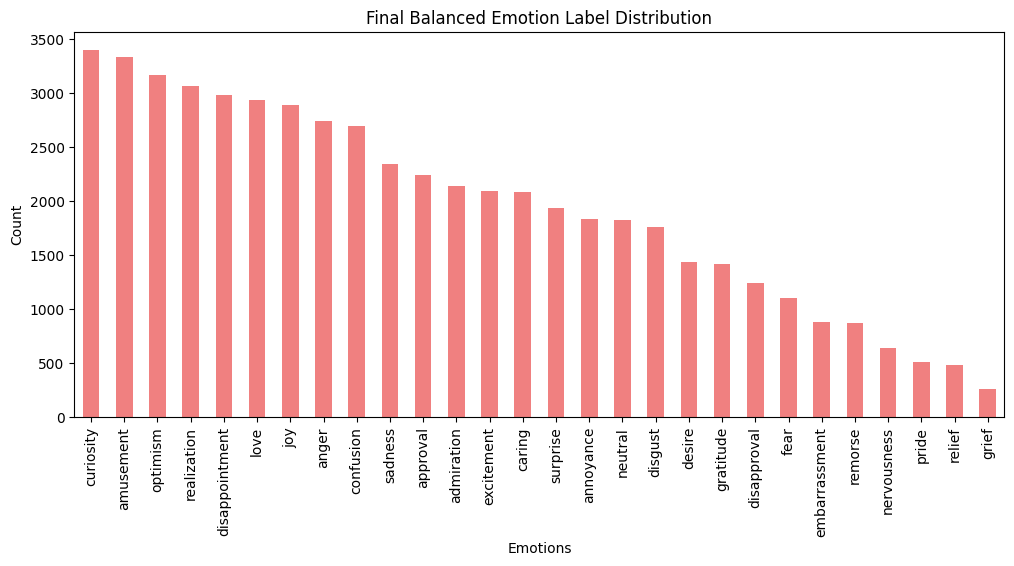

In [40]:
import matplotlib.pyplot as plt

# Counting occurrences of each emotion
new_emotion_counts = df2_balanced.iloc[:, 1:].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
new_emotion_counts.plot(kind="bar", color="lightcoral")
plt.title("Final Balanced Emotion Label Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

### As in the graph, now the dataset is reasonablly balanced upto some extent, so now we will process it further

In [41]:
df2_balanced.head(2)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
32188,[NAME] the curse is real. This ones on you LeB...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1792,"Ooooof, that’s annoying. I’m sorry.",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Preparing the dataset for model input

In [42]:
import torch

# Extract labels (multi-labels)
labels = torch.tensor(df2.iloc[:, 1:].values)  # Assuming label columns start from column index 1

# Create a dataset for PyTorch
dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)

### Loading a pre-trained Bert Model

In [43]:
from transformers import BertForSequenceClassification

# Load BERT model with the correct number of output labels
num_labels = labels.size(1)  # Number of emotion labels
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Pretrained BERT model
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Setting-up training components

In [53]:
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Loss function for multi-label classification
loss_function = BCEWithLogitsLoss()

# Scheduler (optional, for learning rate adjustment)
from transformers import get_scheduler
num_training_steps = len(dataset) // 32 * 2  # Assuming batch size=32 and 2 epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

### Creating dataloaders

In [54]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

## Now finally training the model

### I am fine-tuning the model on only epochs = 2

Epoch 1/2
Training Loss: 0.1071
Validation Loss: 0.1044


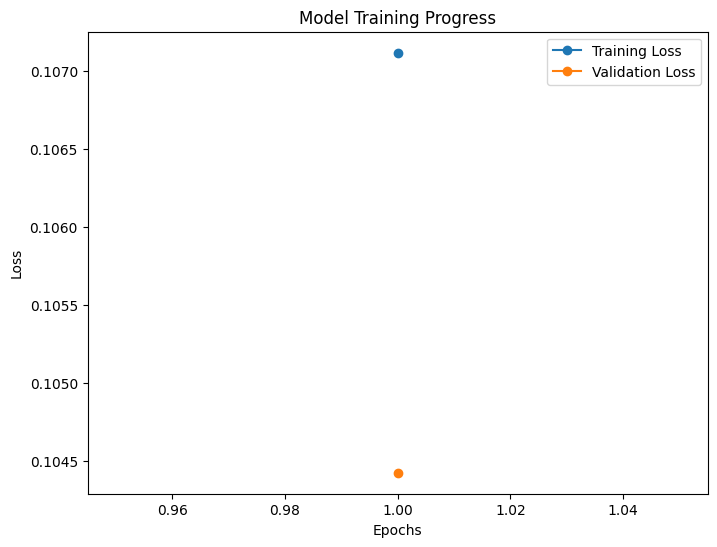

Epoch 1 completed in 1234.71 seconds.
Epoch 2/2
Training Loss: 0.0942
Validation Loss: 0.1063
Epoch 2 completed in 1234.12 seconds.


In [55]:
import time
import torch
from torch.cuda import is_available
from matplotlib import pyplot as plt

# Move model to GPU if available
device = torch.device("cuda") if is_available() else torch.device("cpu")
model.to(device)

# Training loop setup
epochs = 2
train_losses = []
val_losses = []

# Set up Matplotlib figure for real-time plotting
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(8, 6))

# Training loop
for epoch in range(epochs):
    start_time = time.time()
    print(f"Epoch {epoch + 1}/{epochs}")
    
    model.train()  # Set model to training mode
    train_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.float())
        loss = outputs.loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.float())
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Plot training/validation loss
    ax.clear()
    ax.plot(range(1, epoch + 2), train_losses, label="Training Loss", marker="o")
    ax.plot(range(1, epoch + 2), val_losses, label="Validation Loss", marker="o")
    ax.set_title("Model Training Progress")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.pause(0.1)  # Pause to update the plot in real-time

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

# End of training
plt.ioff()  # Turn off interactive mode
plt.show()  # Keep the final plot displayed


### I fine-tuned the model on epochs = 2,  if number of epochs is increased so model can learn more effectively.

### Saving the fine-tuned model.

In [56]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json',
 './fine_tuned_bert/tokenizer.json')

### Evaluating the model using different evaluation metrices

In [59]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss, classification_report

# Put the model in evaluation mode
model.eval()

# Variables to store true labels and predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataloader
with torch.no_grad():
    for batch in val_dataloader:  # Replace with `test_dataloader` if evaluating on a test set
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Apply sigmoid activation to logits for multi-label classification
        probs = torch.sigmoid(logits)

        # Convert probabilities to binary predictions (threshold=0.5)
        predictions = (probs > 0.5).int()

        # Append predictions and true labels
        true_labels.append(labels.cpu().numpy())
        predicted_labels.append(predictions.cpu().numpy())

# Concatenate all batches into single arrays
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1_micro = f1_score(true_labels, predicted_labels, average="micro")
f1_macro = f1_score(true_labels, predicted_labels, average="macro")
precision = precision_score(true_labels, predicted_labels, average="micro")
recall = recall_score(true_labels, predicted_labels, average="micro")
hamming = hamming_loss(true_labels, predicted_labels)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

# Generate a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=list(df2.columns[1:])))

Evaluation Metrics:
Accuracy: 0.3055
F1 Score (Micro): 0.4251
F1 Score (Macro): 0.3165
Precision: 0.5918
Recall: 0.3317
Hamming Loss: 0.0376

Classification Report:
                precision    recall  f1-score   support

    admiration       0.63      0.59      0.61      1155
     amusement       0.61      0.61      0.61       575
         anger       0.53      0.28      0.37       459
     annoyance       0.44      0.05      0.09       888
      approval       0.50      0.15      0.23      1195
        caring       0.47      0.21      0.29       392
     confusion       0.55      0.21      0.30       508
     curiosity       0.43      0.23      0.30       639
        desire       0.48      0.22      0.30       277
disappointment       0.38      0.08      0.13       541
   disapproval       0.42      0.19      0.26       763
       disgust       0.56      0.19      0.28       325
 embarrassment       0.49      0.19      0.27       161
    excitement       0.53      0.16      0.25     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Now finally check the model predictions on some real world examples that I am giving my self to the model.

In [64]:
# Example real-world texts
real_world_texts = [
    "May be, it is possible",
    "I love you",
    "I hate you",
    "Thank to God, I successfully fine-tuned the model",
]

# Tokenize the real-world text examples
encoded_inputs = tokenizer(
    real_world_texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Move inputs to the same device as the model
input_ids = encoded_inputs["input_ids"].to(device)
attention_mask = encoded_inputs["attention_mask"].to(device)

# Put the model in evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Apply sigmoid to convert logits to probabilities
probs = torch.sigmoid(logits)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
predictions = (probs > 0.5).int()

# Map predictions back to labels
predicted_labels = predictions.cpu().numpy()

# Print results
for i, text in enumerate(real_world_texts):
    print(f"Text: {text}")
    print("Predicted Emotions:")
    for label, prediction in zip(df2.columns[1:], predicted_labels[i]):
        if prediction == 1:
            print(f" - {label}")
    print("-" * 50)

Text: May be, it is possible
Predicted Emotions:
--------------------------------------------------
Text: I love you
Predicted Emotions:
 - love
--------------------------------------------------
Text: I hate you
Predicted Emotions:
 - anger
--------------------------------------------------
Text: Thank to God, I successfully fine-tuned the model
Predicted Emotions:
 - gratitude
--------------------------------------------------


## So finally the model shows a reasonable performance on the real world examples.